# Detailed Time Series Analysis and Forecast of the NN (L) Global Sustainable Equity fund

This analysis demonstrates the use of ARIMA models to predict the prices of the NN (L) Global Sustainable Equity fund.

## Imports & data loading

In [1]:
import pandas as pd
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()


    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Data Import

In [3]:
gsef_historical_selected= pd.read_csv('gsef_output/historical_gsef.csv', parse_dates=['Date'], usecols= ["Date", "Close"], dayfirst=True)

In [4]:
gsef_historical_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5511 entries, 0 to 5510
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    5511 non-null   datetime64[ns]
 1   Close   5511 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 86.2 KB


## Data preprocessing

In [5]:
gsef_historical_selected_copy= gsef_historical_selected.copy()

gsef_historical_selected= gsef_historical_selected.set_index('Date')

gsef_historical_selected = gsef_historical_selected.set_index(pd.to_datetime(gsef_historical_selected.index))

#gsef_historical_selected_resampled.index = pd.to_datetime(gsef_historical_selected_copy.index, unit='d')

#gsef_historical_selected_copy.info()

In [6]:
#gsef_historical_selected_resampled= gsef_historical_selected_copy.resample('M').mean()

In [7]:
#gsef_historical_selected.head()

In [8]:
#gsef_historical_selected_copy

## Data analysis

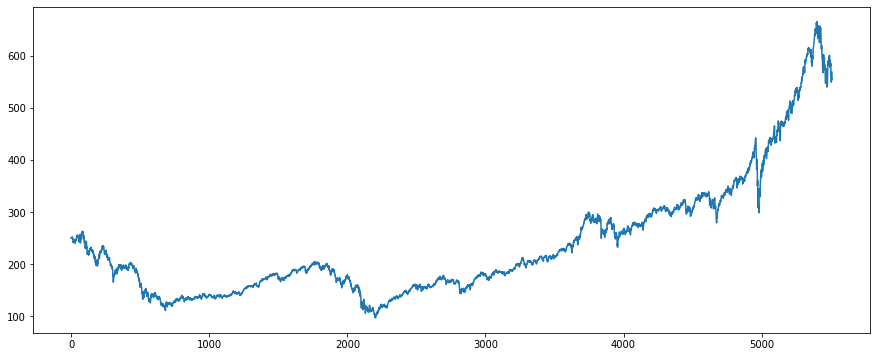

In [9]:
# Visualise the prices
y = gsef_historical_selected_copy.Close   
y.plot(figsize=(15, 6))
plt.show()

We see that there's a positive trend and that the variance increases throughout the last 2 years.

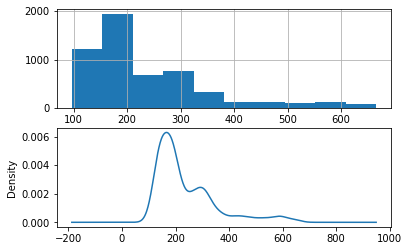

In [10]:
# Generate a KDE plot to analise the distribution of the data
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.hist()
pyplot.subplot(212)
y.plot(kind='kde')
pyplot.show()

The data has a right-skewed distribution.

We then visualise the trend, seasonality and random residual components.

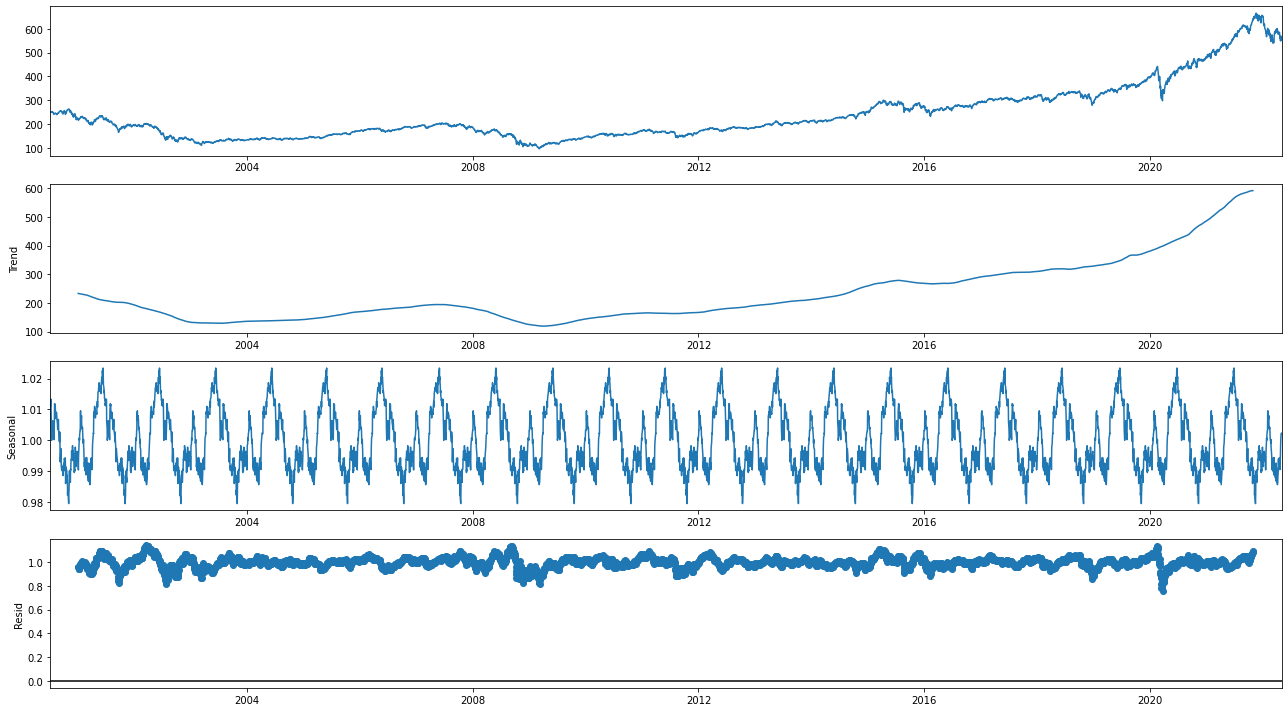

In [11]:
# Decompose the time series into components
rcParams['figure.figsize']= 18, 10
decomposition= sm.tsa.seasonal_decompose(gsef_historical_selected, model= 'multiplicative', period= 253)

fig= decomposition.plot()

plt.show()

In the chart above we can clearly see the seasonal component of the data, we can also see the separate upward trend of the data, as well as the relatively low noise throughout the years - except for the middle 2008, the beginning of 2020 and the beginning of 2021, where noise increases.

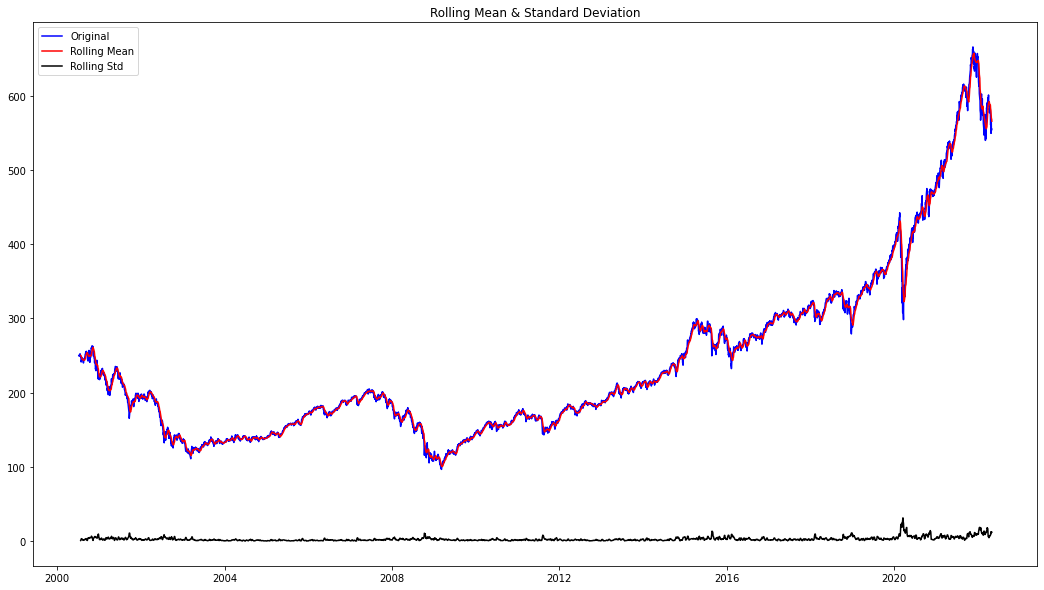

Results of Dickey-Fuller Test:
Test Statistic                    1.461690
p-value                           0.997377
#Lags Used                       25.000000
Number of Observations Used    5485.000000
Critical Value (1%)              -3.431543
Critical Value (5%)              -2.862067
Critical Value (10%)             -2.567051
dtype: float64


In [12]:
# Check whether the time series is stationary or not
test_stationarity(gsef_historical_selected)

The rolling mean has an upwards trend and the standard deviation slighlty varies during the last 2 years. 

Since the p-value of the Dickey-Fuller Test (0.998078) is greater than 0.05, we have to accept the null hypothesis that **the time series is not stationary**.

In [13]:
#y = gsef_historical_selected['Close'].values

In [14]:
y = gsef_historical_selected['Close']

In [15]:
#y

## Convert the non stationary time series to a stationary time series

There are 2 main factors that could cause a time series data set to be non-stationary:

1. **Trend** - Occurs when the time series has an average that is variable over time. For example, in this case we saw that, on average, the was increasing over time.

2. **Seasonality** - Variations during specific time periods. For example, we se that there's a seasonal trend where prices tend to rise around the month of May, and tend to decrease at the beginning of each year. 

### Transformations

- We can apply transformations that penalise high values more than low values. These transformations can work on row level, based on square root, cube root, or even log transformation. We will take here a log scale transformation for simplicity.

#### Log Scale Transformation

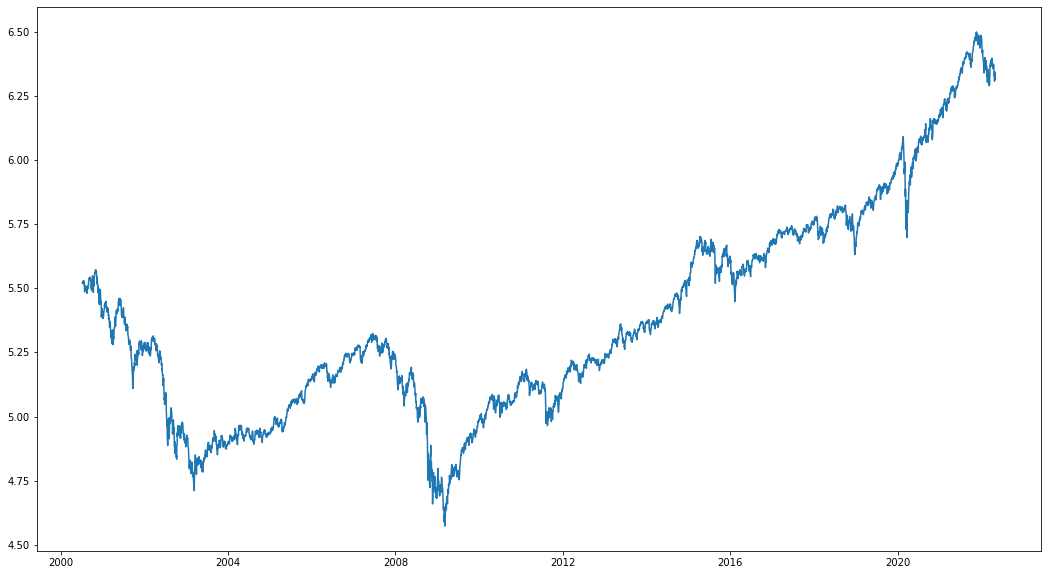

In [16]:
ts_log= np.log(y)
plt.plot(ts_log)

#### Other possible transformations that we can apply to convert non stationary time series datasets to stationary are::
- Exponential transformation
- Box Cox transformation
- Square root transformation

#### **Techniques to remove the Trend - Smoothing**
- Smoothing means calculating moving averages for a certain time window

##### Moving average
- We take the mean of "k" consecutive values, depending on the frequency of the time series.
- Here we can take the average value of trading days per year year, in this case, 253 days.
- A drawback of this specific approach is that the time period should be strictly defined.

We apply the moving average on the data set that has been transformed by the log transformation.

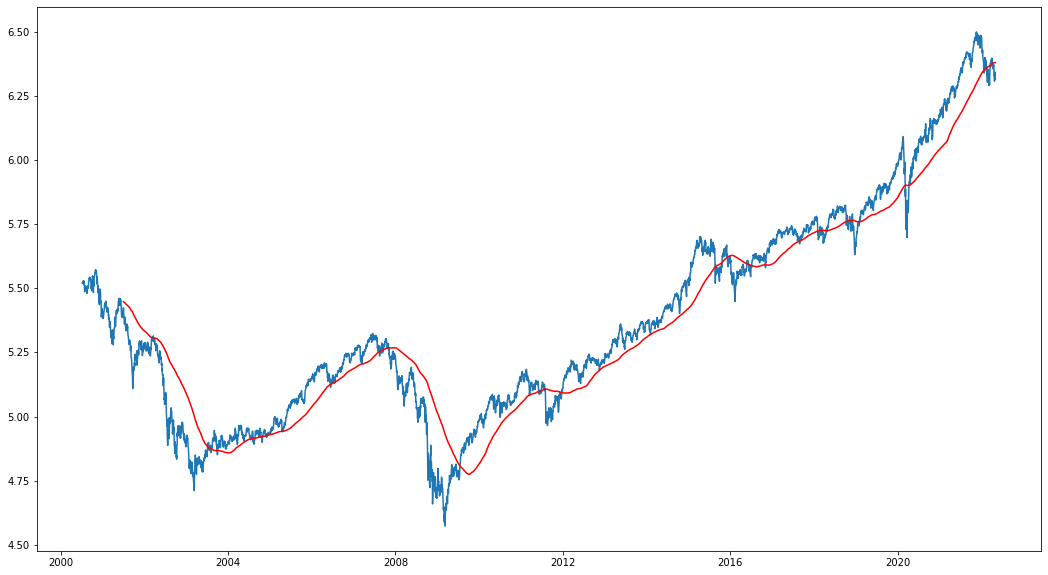

In [17]:
moving_avg= ts_log.rolling(253).mean()

plt.plot(ts_log)
plt.plot(moving_avg, color= 'red')

In the previous graph we can see how we slightly helped in removing the trend.

Next, we have to calculate the difference, to further remove the trend of the time series. For that, we substract the moving average data set from the original data set that has been logarithmically transformed. In other words, we will only show the differences. When the moving average's value is null (for the first 253 values/days), no value will appear for the difference.

In [18]:
ts_log_moving_avg_diff = ts_log - moving_avg

#ts_log_moving_avg_diff.tail()

We then remove the null values and test the stationarity of the difference data set through applying the "test_stationarity" on the difference data set. And we see that the moving average and standard deviation lines are better maintained throughout the years.

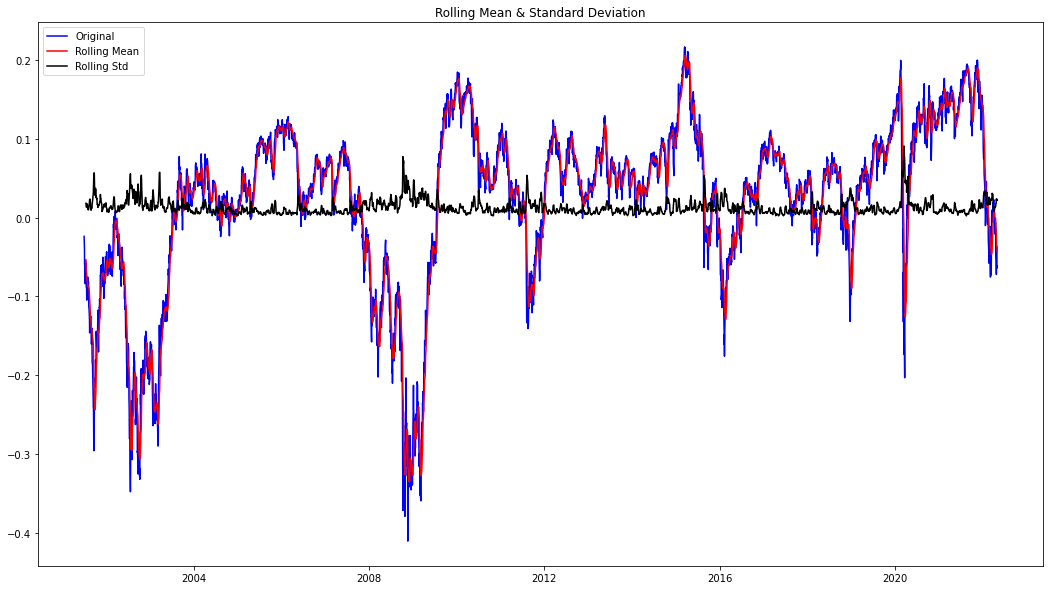

Results of Dickey-Fuller Test:
Test Statistic                   -3.736622
p-value                           0.003627
#Lags Used                       16.000000
Number of Observations Used    5242.000000
Critical Value (1%)              -3.431598
Critical Value (5%)              -2.862092
Critical Value (10%)             -2.567064
dtype: float64


In [19]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

And as we see in the results of the Dickey-Fuller test, we have signficantly improved the p-value and decreased it to 0.03, which is less than 0.05. This means that our data set is now stationary, and now we can start training a model.

We can continue improving the transformation of the data set, for example, by applying the Exponential Weighted Moving Average. 

#### Exponential Weighted Moving Average:
- To overcome the problem of choosing a window defined in the moving average, we can use the exponential weighted moving average.
- We take a "weighted moving average" where the most recent values receive a higher weight.
- There can be many techniques for assigning weights. A popular one is the exponentially weighted moving average where weights are assigned to all previous values with a decay factor.

We visualise the results of the transformation in the red line on the following chart.

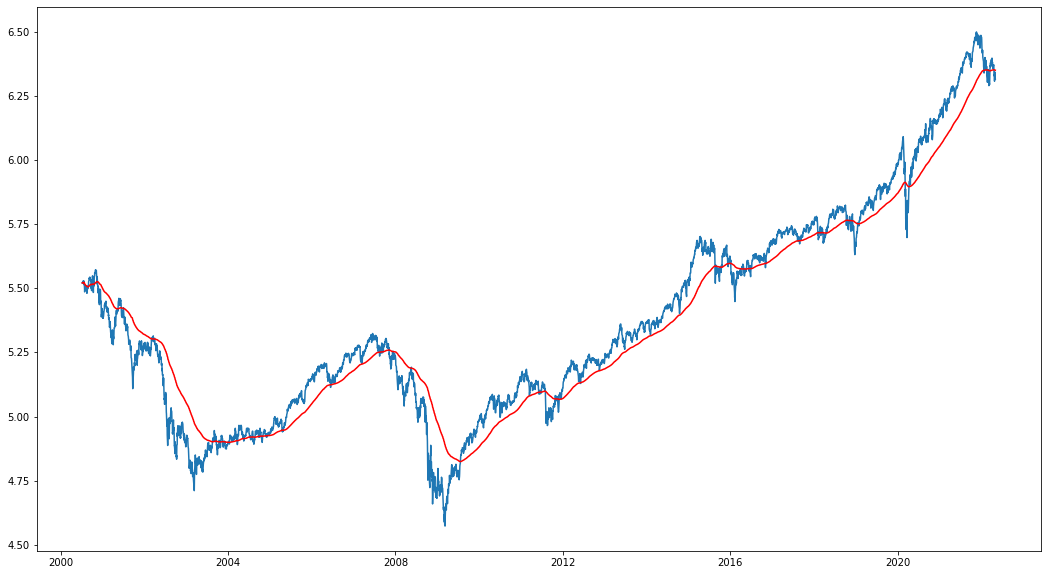

In [20]:
expwighted_avg = ts_log.ewm(span=253).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

And now we have to substract this exponential weighted moving average from the original data set (with the logarithmic transformation applied) and we apply the "test_stationarity" to see if the "ts_log_ewma_diff" data set is stationary.

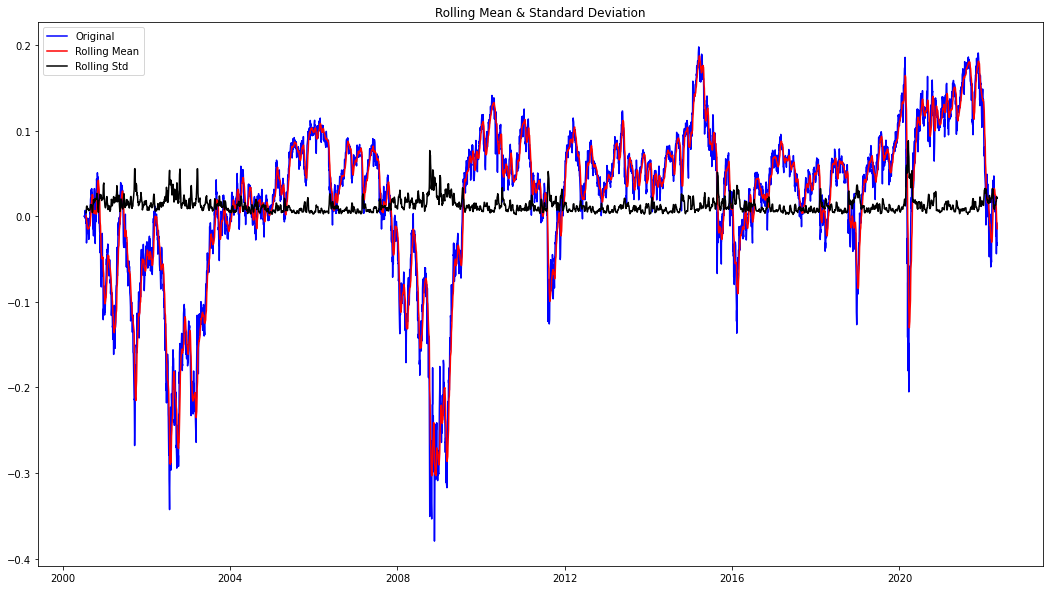

Results of Dickey-Fuller Test:
Test Statistic                   -4.210655
p-value                           0.000632
#Lags Used                       10.000000
Number of Observations Used    5500.000000
Critical Value (1%)              -3.431540
Critical Value (5%)              -2.862066
Critical Value (10%)             -2.567050
dtype: float64


In [21]:
ts_log_ewma_diff = ts_log - expwighted_avg
test_stationarity(ts_log_ewma_diff)

We check the results of the Dickey-Fuller Test and see that the p-value is equal to 0.009, which is less than 0.05, which is a singinficant improvement with respect to the previous transformation. Therefore, we can use this data set to train our models.

#### More techniques to remove seasonality and trend

Finally, there are more techniques to remove seasonality.

- The simple trend reduction techniques discussed above do not work in all cases, especially in data sets that have high seasonality.

#### Differentiation
- In this technique, we take the difference between an observation at a particular instant and that of the previous instant.

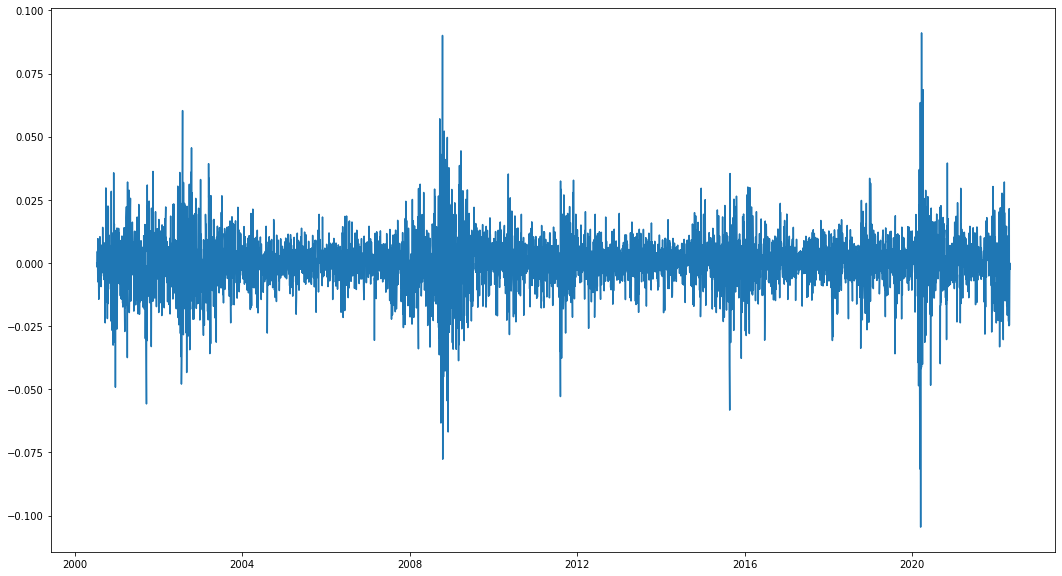

In [22]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

If we remove the null values using the "dropna" function and we re-apply the "test_stationarity" funciton, we see that the p-value in the Dickey-Fuller Test is equal to 0, which is a better result than p-value of the data set in the previous transofrmation.

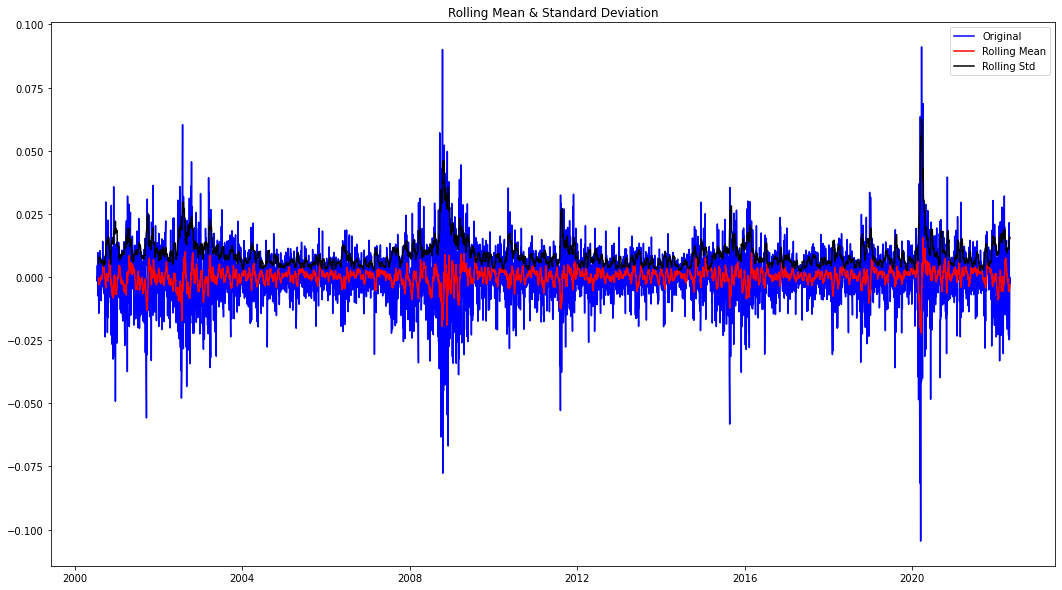

Results of Dickey-Fuller Test:
Test Statistic                  -23.522947
p-value                           0.000000
#Lags Used                        9.000000
Number of Observations Used    5500.000000
Critical Value (1%)              -3.431540
Critical Value (5%)              -2.862066
Critical Value (10%)             -2.567050
dtype: float64


In [23]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Decomposition

- Finally, another technique that we can use is the "decomposition". In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

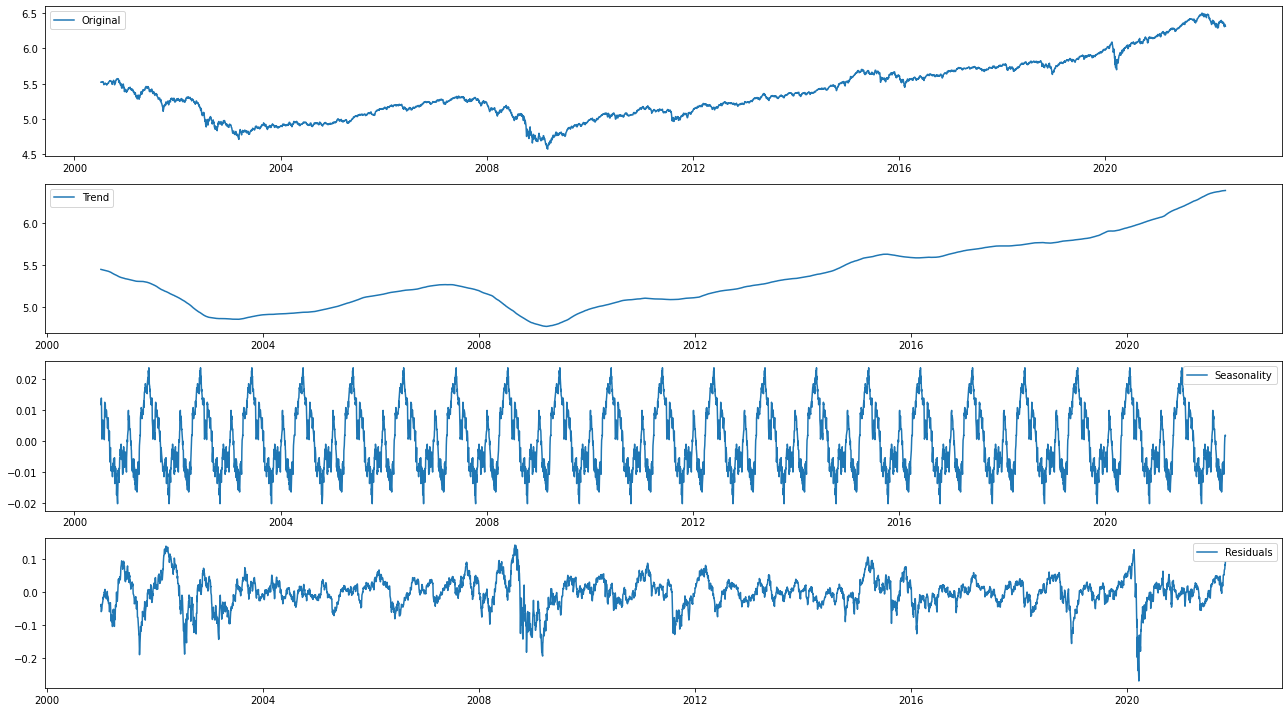

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, period= 253)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Now that we have transformed our data set to be stationary, we can start training different predictive time series models.

# Time Series Forecast

## Autoregression (AR)

- The Autoregression (AR) method models the next step in the sequence as a linear function of the observations in the previous time steps.
- The number of AR terms (autoregressive) (p): p is the parameter associated with the autoregressive aspect of the model, which incorporates past values, that is, lags of the dependent variable. For example, if p is 5, the predictors of x(t) will be x(t-1)… .x(t-5).

In [25]:
from statsmodels.tsa.ar_model import AutoReg
from random import random

In [26]:
ts_log_diff.head()

Date
2000-07-10    0.000000
2000-07-11    0.000000
2000-07-12   -0.001561
2000-07-13    0.000761
2000-07-14    0.004593
Name: Close, dtype: float64

In [27]:
# fit model
ar_model = AutoReg(ts_log_diff, lags=None, seasonal=True, period= 506, trend= 'ct')
ar_model_fit = ar_model.fit()

C:\Users\n1564253\Anaconda3\envs\gsef\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [28]:
# Print the AutoReg Model Results
# model_fit.summary()

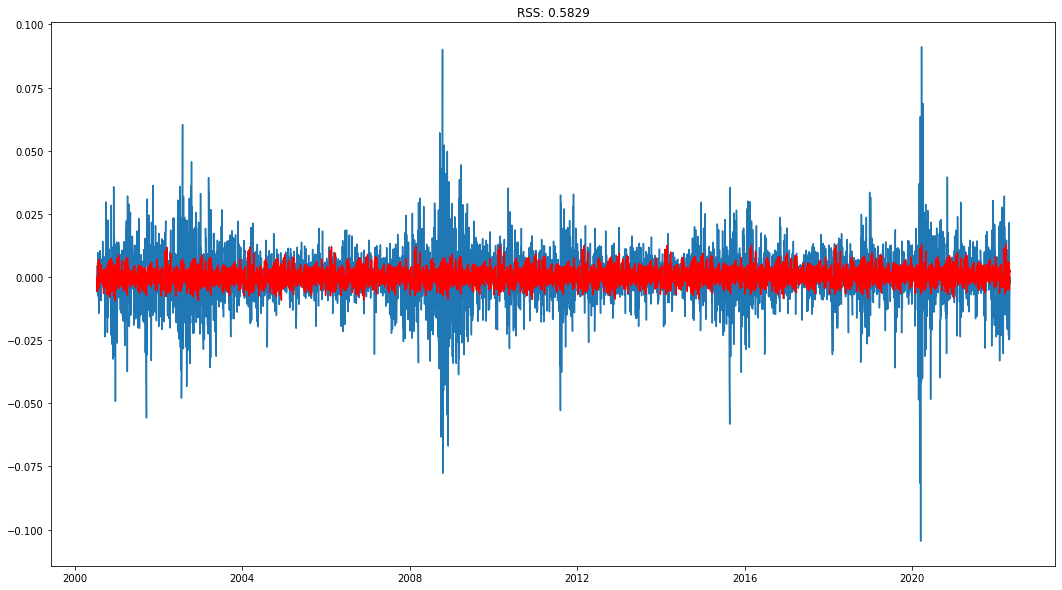

In [29]:
plt.plot(ts_log_diff)
plt.plot(ar_model_fit.fittedvalues, color='red')
plt.title('RSS: %.4f'% np.nansum((ar_model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reverse the transformations

Fitted or predicted values:

We transform the data set of fitted values to a dataframe using the "pd.Series" function.

In [30]:
predictions_AR_diff = pd.Series(ar_model_fit.fittedvalues, copy=True)

# Print the predictions of the model of the whole dat aset
#predictions_ARIMA_diff.head()

We then perform a cumulative sum to invert the differentiation:

#### Cumulative sum to reverse the differentiation: 

In [31]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
#predictions_ARIMA_diff_cumsum.head()

#### Add the value of the first month that was previously removed when substracting:

In [32]:
predictions_AR_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
#predictions_ARIMA_log.head()

#### Applying the exponential to reverse the logarithmic transformation:

In [33]:
predictions_AR = np.exp(predictions_AR_log)

Text(0.5, 1.0, 'RMSE: 38.2060')

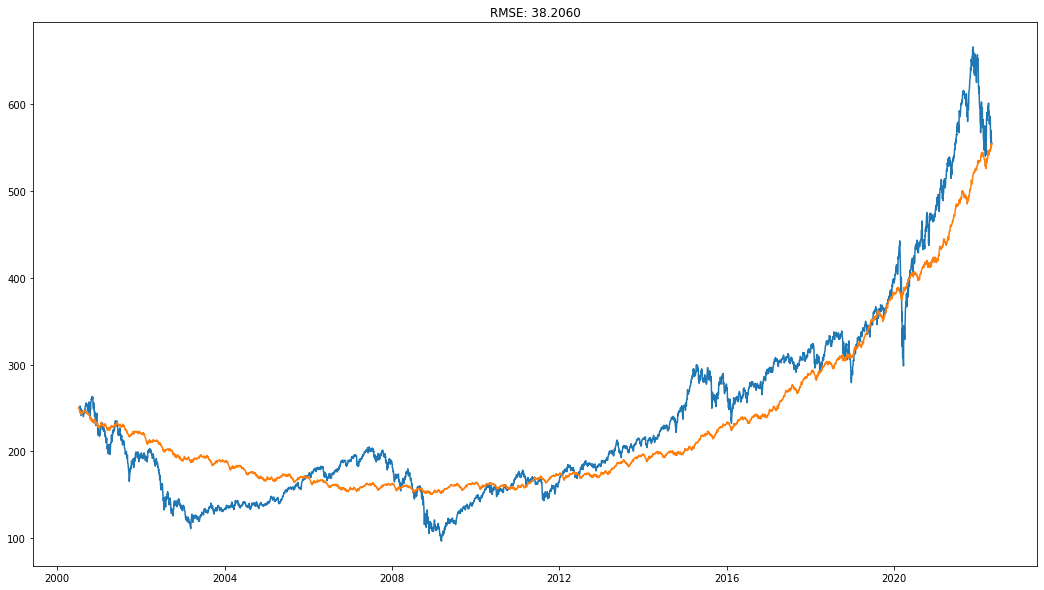

In [34]:
plt.plot(y)
plt.plot(predictions_AR)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_AR-y)**2)/len(y)))

### Forecast Quality Score Metrics
- __R-square__
- __Mean Absolute Error__
- __Mean absolute error__
- __Mean square error__
- __Logarithmic mean square error__
- __Mean absolute percentage error__

In [35]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1].
For the R squared, the closest the value is to 1, the better the model, and the closest it is to 0, the worst the model is.

- sklearn.metrics.r2_score

In [36]:
r2_score(y, predictions_AR)

0.891293280741961

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [37]:
mean_absolute_error(y, predictions_AR)

29.827279484148665

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [38]:
median_absolute_error(y, predictions_AR)

24.919062557657185

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error

In [39]:
mean_squared_error(y, predictions_AR)

1459.6983453031921

In general, except for the R-squared (R2), the lower the value of Quality Score Metrics, the better is the model.

__Mean Squared Logarithmic Error (MSLE)__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [40]:
mean_squared_log_error(y, predictions_AR)

0.029487826607771488

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), The lowest the Mean Absolute Percentage Error, the better is the model. The closest the Mean Absolute Percentage Error is to 0, the better is the model.<br>
For example, a Mean Absolute Percentage Error above 50 would mean that the model is poor and that is not predicting correctly.

The Mean Absolute Percentage Error metric is not available in sklearn.

In [41]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [42]:
mean_absolute_percentage_error(y, predictions_AR)

14.233720149645343

__Function to evaluate forecast using above metrics:__

In [43]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [44]:
evaluate_forecast(y, predictions_AR)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,mape,rmse
0,0.891293,29.827279,24.919063,1459.698345,0.029488,14.23372,38.205999


- RMSE has the advantage of penalizing larger errors more, so it may be more appropriate in some cases, for example if being out of 10 is more than twice as bad as being out of 5. But if being out of 10 is just twice as bad. as if it were 5, then MAE is more appropriate.

- From the point of view of interpretation, MAE is clearly the winner. RMSE does not describe the average error alone and has other implications that are more difficult to figure out and understand.

- On the other hand, a clear advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is not desirable in many mathematical calculations.